In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
data_dir = "Dataset"  # Replace with actual dataset path
img_size = 224

# Define transforms for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training_set'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Test_set'), data_transforms['test'])

# Split training dataset into train and validation (80:20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Apply validation transform to validation dataset
val_dataset.dataset.transform = data_transforms['val']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get class names and number of classes
class_names = full_train_dataset.classes  # ['Abnormal', 'Normal']
num_classes = len(class_names)

# 2. Load Pre-trained VGG16
model = models.vgg16(pretrained=True)
# Freeze convolutional layers to reduce training time
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier for binary classification
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Optimize only classifier parameters

# 4. Training Loop with Validation
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='binary')
            epoch_recall = recall_score(all_labels, all_preds, average='binary')
            epoch_f1 = f1_score(all_labels, all_preds, average='binary')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
                  f'Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    torch.save(model.state_dict(), '/content/drive/MyDrive/pretrained_model/best_vgg16_model.pth')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig('/content/drive/MyDrive/pretrained_model/vgg16_metrics.png')
    plt.close()

    return model, best_val_acc

# 5. Test Model
def test_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    running_corrects = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_precision = precision_score(all_labels, all_preds, average='binary')
    test_recall = recall_score(all_labels, all_preds, average='binary')
    test_f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Test Accuracy: {test_acc:.4f} Precision: {test_precision:.4f} '
          f'Recall: {test_recall:.4f} F1: {test_f1:.4f}')

# Train and validate the model
start_time = time.time()
model, best_val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
print(f'Training completed in {time.time() - start_time:.2f} seconds')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# Test the model
print('\nTesting model...')
test_model(model, dataloaders['test'])

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
data_dir = "/content/drive/MyDrive/Dataset"  # Replace with the actual path to your Dataset folder
img_size = 224

# Define transforms for training and test sets
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'Training_set'), data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'Test_set'), data_transforms['test'])
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'test']
}
class_names = image_datasets['train'].classes  # ['Abnormal', 'Normal']
num_classes = len(class_names)

# 2. Load Pre-trained ResNet-50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)  # Modify for binary classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), '/content/drive/MyDrive/pretrained_model/best_model.pth')
    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)


In [ ]:

# 5. Grad-CAM for Explainability
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_image, class_idx=None):
        self.model.eval()
        input_image = input_image.to(device)
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        score = output[0, class_idx]
        self.model.zero_grad()
        score.backward()
        gradients = self.gradients.data
        activations = self.activations.data
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = nn.functional.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.squeeze().cpu().numpy()
        return cam

def visualize_gradcam(model, image_path, target_layer):
    transform = data_transforms['test']
    # Read the image and check if it loaded successfully
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the path and file format.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert NumPy array to PIL Image before applying transforms
    from PIL import Image
    image_pil = Image.fromarray(image)

    image_tensor = transform(image_pil).unsqueeze(0)
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate(image_tensor)
    cam = cv2.resize(cam, (img_size, img_size))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    # Resize the original image (now a NumPy array) for display
    image_display = cv2.resize(image, (img_size, img_size)) / 255
    superimposed_img = heatmap * 0.4 + image_display # Use the resized NumPy array for superimposition
    superimposed_img = np.clip(superimposed_img, 0, 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_display) # Display the resized NumPy array
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage of Grad-CAM
model.load_state_dict(torch.load('/content/drive/MyDrive/pretrained_model/best_model.pth'))
model.eval()
target_layer = model.layer4[-1].conv3  # Last convolutional layer in ResNet-50
visualize_gradcam(model, "/content/drive/MyDrive/Dataset/Test_set/Abnormal/C_0389_1.RIGHT_MLO.png", target_layer)

# 7. Evaluate Model
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

evaluate_model(model, dataloaders['test'])

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (same as your setup)
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Use num_classes from your dataset
)
model.load_state_dict(torch.load('/content/drive/MyDrive/pretrained_model/best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Define the test transform (same as your test dataset)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to preprocess image for LIME
def get_image(path):
    img = Image.open(path).convert('RGB')
    return img

# Function to convert image to tensor for model prediction
def get_input_tensors(img):
    transform = test_transform
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor.to(device)

# Modified predict_proba function to handle batch of images
def predict_proba(images):
    # images: 4D numpy array [num_samples, height, width, channels]
    probs = []
    for image in images:
        # Convert single image (3D: [height, width, channels]) to PIL
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        img_tensor = get_input_tensors(image)
        with torch.no_grad():
            outputs = model(img_tensor)
            prob = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        probs.append(prob[0])  # Remove batch dimension from prob
    return np.array(probs)

# Load a test image (replace with actual path)
test_image_path = os.path.join(data_dir, 'Test_set', class_names[0], '/content/drive/MyDrive/Dataset/Test_set/Abnormal/C_0389_1.RIGHT_MLO.png')  # Update with actual path
img = get_image(test_image_path)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Use a segmentation algorithm
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)

# Explain the prediction
explanation = explainer.explain_instance(
    np.array(img),
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmentation_fn
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {class_names[explanation.top_labels[0]]}')
plt.axis('off')
plt.show()

In [1]:
!pip install lime
!pip install tf-explain

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━

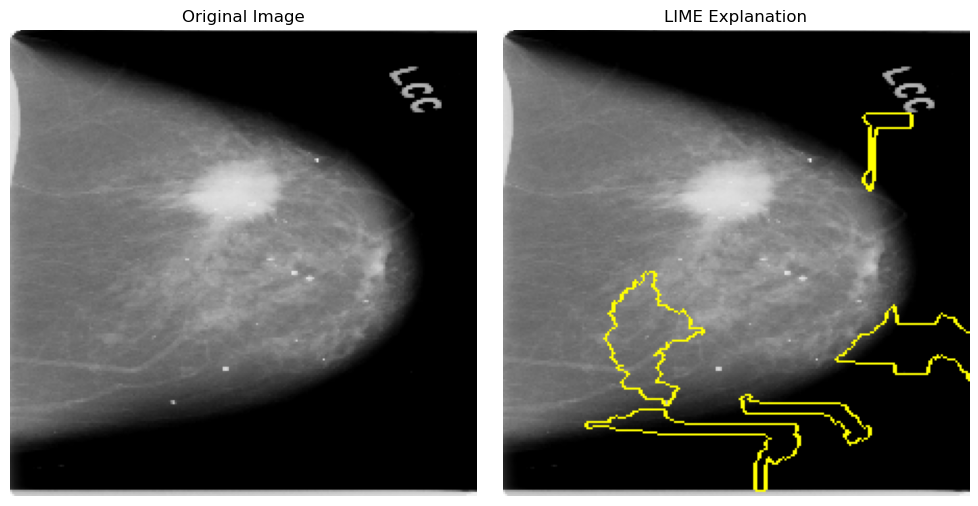

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Prediction: Benign (Probability: 0.0002)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load the trained VGG16 model
model = load_model('vgg16_finetuned11_final.keras')

# Function to preprocess image for VGG16
def preprocess_image(image_path):
    # Load image and resize to 224x224 (VGG16 input size)
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    # Normalize pixel values to [0, 1]
    img = img / 255.0
    # Expand dimensions to match model input shape (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict with the model (for LIME)
def predict_fn(images):
    # Images come from LIME as a batch of perturbed images
    # Ensure images are in the correct format for VGG16
    images = np.array([img / 255.0 if img.max() > 1 else img for img in images])
    # Get model predictions
    preds = model.predict(images)
    return preds

# Load and preprocess a sample image
image_path = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\custom\Abnormal\set3\1.3.6.1.4.1.9590.100.1.2.253992292511749643718075355262495714002_1-1.png'  # Replace with your image path
original_image = load_img(image_path, target_size=(224, 224))
original_image_array = img_to_array(original_image) / 255.0
preprocessed_image = preprocess_image(image_path)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
# num_samples: number of perturbed images to generate
# top_labels: number of top predictions to explain (1 for binary classification)
explanation = explainer.explain_instance(
    original_image_array,
    predict_fn,
    top_labels=1,
    hide_color=0,  # Replace superpixels with black during perturbation
    num_samples=1000  # Number of perturbations (adjust for speed vs. accuracy)
)

# Get the explanation for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,  # Show only positive contributions
    num_features=5,  # Number of superpixels to highlight
    hide_rest=False  # Show the entire image with highlighted regions
)

# Plot the original image and LIME explanation
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image_array)
plt.axis('off')

# LIME explanation with superpixel boundaries
plt.subplot(1, 2, 2)
plt.title('LIME Explanation')
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')

plt.tight_layout()
plt.savefig('lime_explanation.png')  # Save the plot
plt.show()

# Print model prediction
prediction = model.predict(preprocessed_image)[0][0]
class_label = 'Malignant' if prediction >= 0.5 else 'Benign'
print(f'Model Prediction: {class_label} (Probability: {prediction:.4f})')

In [6]:
!pip install Shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   -------------------------------------- - 524.3/545.3 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 2.3 MB/s eta 0:00:00


In [6]:
pred = model.predict(x_input)
print("Prediction probabilities:", pred)


NameError: name 'x_input' is not defined

In [28]:
import shap


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


PartitionExplainer explainer: 3it [00:21, 10.97s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..213.0].


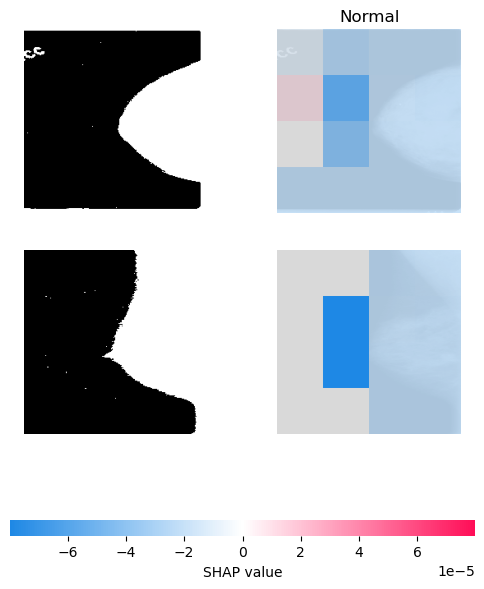

In [5]:
import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import os

# ========== CONFIG ==========
model_path = "vgg16_finetuned11_final.keras"
img_path =  r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\DDSM_binary\Dataset_large\Test_set\Abnormal\1.3.6.1.4.1.9590.100.1.2.210796469212726064906048175661188744072_1-1.png'  # Replace with your image path
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\DDSM_binary\Dataset_large\Training_set\Abnormal" 


class_names = ["Normal", "Abnormal"]
img_size = 224

# ===== LOAD MODEL =====
model = load_model(model_path)

# ===== LOAD MULTIPLE IMAGES =====
def load_images_from_folder(folder, max_images=5):
    images = []
    for fname in os.listdir(folder):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, fname)
            img = image.load_img(img_path, target_size=(img_size, img_size))
            img_array = image.img_to_array(img)
            images.append(img_array)
            if len(images) >= max_images:
                break
    return np.array(images)

# Load a few images for SHAP explanation
X = load_images_from_folder(data_dir, max_images=5)
X_preprocessed = preprocess_input(X.copy())  # We'll use this inside f(x)

# ===== DEFINE PREDICT FUNCTION =====
def f(x):
    x_copy = x.copy()
    x_preprocessed = preprocess_input(x_copy)
    return model.predict(x_preprocessed)

# ===== DEFINE MASKER =====
masker = shap.maskers.Image("blur(64,64)", X[0].shape)

# ===== CREATE EXPLAINER =====
explainer = shap.Explainer(f, masker, output_names=class_names)

# ===== EXPLAIN IMAGES =====
shap_values = explainer(
    X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:2]
)

# ===== PLOT RESULTS =====
shap.image_plot(shap_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\shap\plots\_image.py:185: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = axes[row, i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)


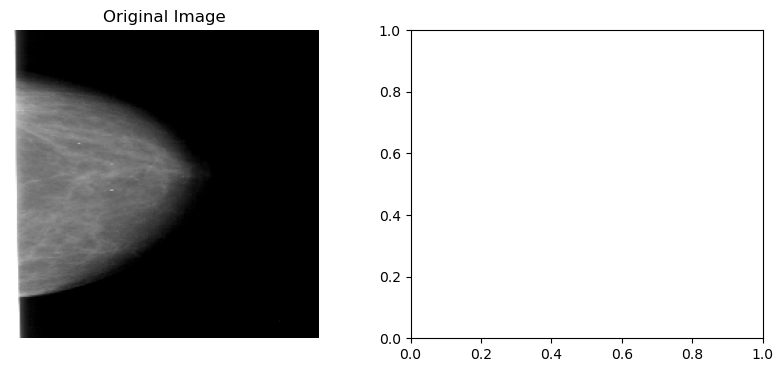

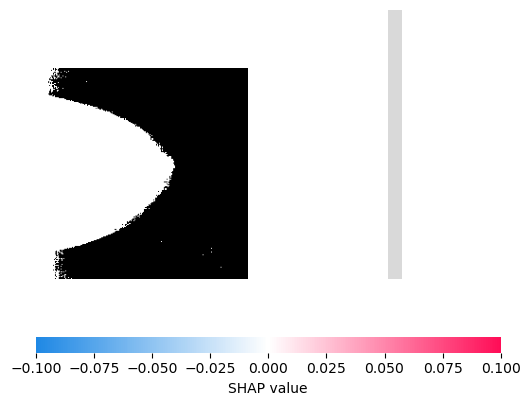

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


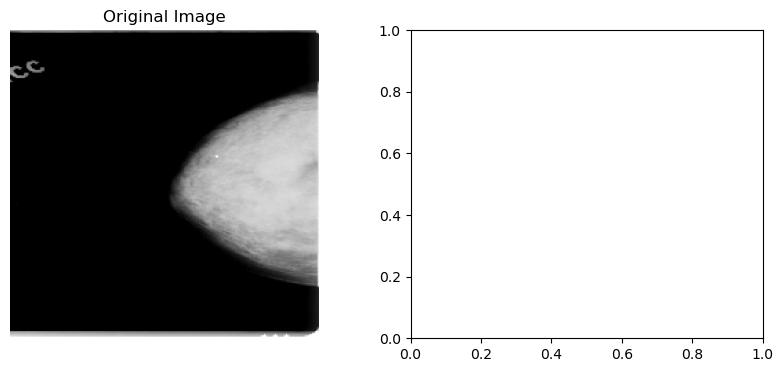

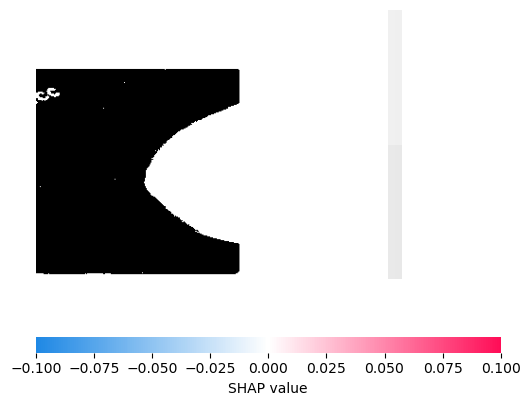

In [4]:
for i in range(len(shap_values.values)):
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X[i].astype(np.uint8))
    plt.title("Original Image")
    plt.axis('off')
    
    # SHAP explanation
    plt.subplot(1, 2, 2)
    shap.image_plot([shap_values[i]], X[i:i+1])  # Corrected input


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os

# Set paths
base_dir = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset'
train_dir = os.path.join(base_dir, 'Training_set')
test_dir = os.path.join(base_dir, 'Test_set')
IMG_SIZE = 224
BATCH_SIZE = 16

# Data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2  # 20% for validation
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Training and validation from training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='training'  # 80% for training
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'  # 20% for validation
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model (initial training with frozen base)
model.fit(train_generator, epochs=10, validation_data=validation_generator)


# Fine-tune
base_model.trainable = True
for layer in base_model.layers[:143]:  # Freeze up to conv4_block1_out
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=5, validation_data=validation_generator)

# Save fine-tuned model
model.save('resnet50_finetuned.keras')
print("Fine-tuned model saved as 'resnet50_finetuned.h5'")

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Preprocess image for Grad-CAM
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Select a test image
test_image_path = os.path.join(test_dir, 'Abnormal', os.listdir(os.path.join(test_dir, 'Abnormal'))[0])
test_image = preprocess_image(test_image_path)

# Get model prediction
pred = model.predict(test_image)
class_index = 1 if pred[0][0] > 0.5 else 0
class_label = 'Abnormal' if class_index == 1 else 'Normal'
print(f"Prediction for test image: {pred[0][0]:.4f} ({class_label})")



Found 1312 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 322 images belonging to 2 classes.


C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.4851 - loss: 0.8409 - val_accuracy: 0.5000 - val_loss: 0.6989
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.4894 - loss: 0.6995 - val_accuracy: 0.5061 - val_loss: 0.6929
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5264 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.5236 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5258 - loss: 0.6933 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5064 - loss: 0.6932 - val_accuracy: 0.5000 - v

C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_358']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/